## Import packages

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Seed


In [2]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Config


In [9]:
# Data
TICKER = "NVDA"
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"

In [ ]:
# Preprocessing
SEQ_LEN = 30 #input(use 30 days to predict)
N_FORECAST = 1 #(number of day need to predicted)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15

In [70]:
# Optimze ARO
ARO_POP_SIZE = 15 # Number rb in population
ARO_MAX_ITER = 25 # Number of iteration to optimize
# [hidden_size, num_layers, learning_rate]
ARO_LOWER_BOUND = [16, 1, 0.0001]
ARO_UPPER_BOUND = [128, 3, 0.01]
EPOCHS = 100
BATCH_SIZE = 32

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Use device: {DEVICE}")

Use device: cpu


## EDA

In [10]:
data = yf.download(TICKER, start=START_DATE, end=END_DATE)

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_15908\122219383.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


In [11]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-02,5.971409,5.971409,5.892010,5.942536,237536000
2020-01-03,5.875832,5.919639,5.826798,5.851689,205384000
2020-01-06,5.900472,5.905699,5.756358,5.782493,262636000
2020-01-07,5.971908,6.017706,5.883796,5.928847,314856000
2020-01-08,5.983108,6.024425,5.927603,5.967676,277108000


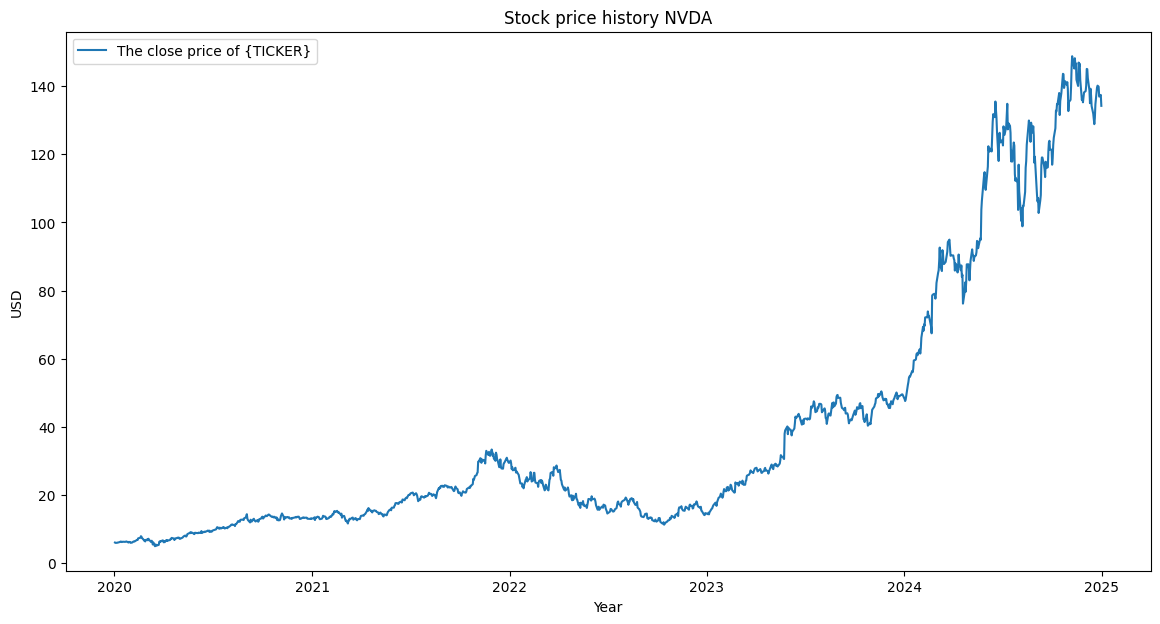

In [13]:
# Visualize the close price
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label="The close price of {TICKER}")
plt.title(f"Stock price history {TICKER}")
plt.xlabel("Year")
plt.ylabel("USD")
plt.legend()
plt.show()

## Data preprocessing

In [14]:
# Get the close price and scaling
close_prices = data[['Close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(close_prices)

In [15]:
# Function to create a sequences
def create_seqences(dataset, seq_length, n_out):
    X, y = [], []
    for i in range(len(dataset) - seq_length - n_out + 1):
        X.append(dataset[i : i + seq_length])
        y.append(dataset[i + seq_length : i + seq_length + n_out])
    return np.array(X), np.array(y).reshape(-1, n_out)

In [32]:
# Split dataset into Train, Validation, Test
train_size = int(len(scaled)*TRAIN_RATIO)
val_size = int(len(scaled)*VAL_RATIO)
test_size = len(scaled) - train_size - val_size

train_data = scaled[0:train_size]
val_data = scaled[train_size - SEQ_LEN : train_size + val_size]
test_data = scaled[train_size + val_size - SEQ_LEN :]

In [33]:
# Create a sequences for each set
X_train, y_train = create_seqences(train_data, SEQ_LEN, N_FORECAST)
X_val, y_val = create_seqences(val_data, SEQ_LEN, N_FORECAST)
X_test, y_test = create_seqences(test_data, SEQ_LEN, N_FORECAST)

In [34]:
# Convert to Pytorch Tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [36]:
print(f"Size of training data(X, y): {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Size of val data(X, y): {X_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Size of test data(X, y): {X_test_tensor.shape}, {y_test_tensor.shape}")

Size of training data(X, y): torch.Size([850, 30, 1]), torch.Size([850, 1])
Size of val data(X, y): torch.Size([188, 30, 1]), torch.Size([188, 1])
Size of test data(X, y): torch.Size([190, 30, 1]), torch.Size([190, 1])


## Build model

In [41]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x) # lstm_out có shape (batch, seq_len, hidden_size)
        out = self.fc(lstm_out[:, -1, :]) # lấy output của bước thời gian cuối cùng (out[:, -1, :])
        return out

In [37]:
class CNNModel(nn.Module):
    def __init__(self, input_size=1, n_kernels=64, kernel_size=3, output_size=1):
        super().__init__()
        # Conv1d cần đầu vào có shape (batch_size, input_size, seq_length)
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=n_kernels, kernel_size=kernel_size)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        
        # Tự động tính kích thước đầu vào cho lớp Linear
        # Tạo một đầu vào giả để xác định kích thước sau lớp conv và pool
        dummy_input = torch.randn(1, SEQ_LEN, input_size).permute(0, 2, 1)
        conv_out = self.pool(self.relu(self.conv1(dummy_input)))
        flatten_out_size = conv_out.shape[1] * conv_out.shape[2]
        
        self.fc1 = nn.Linear(flatten_out_size, 100)
        self.fc2 = nn.Linear(100, output_size)

    def forward(self, x):
        # x có shape: (batch, seq_len, input_size)
        # Permute sang (batch, input_size, seq_len) cho Conv1d
        x = x.permute(0, 2, 1)
        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training


In [50]:
def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Func to train, evaluate
    """
    model.to(DEVICE)

    #initia loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

    #DataLoader
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)

    #Interation of training
    train_losses = []
    val_losses = []
    for epoch in range(EPOCHS):
        model.train()
        batch_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())


        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)        

        model.eval()
        with torch.no_grad(): 
            val_preds = model(X_val_tensor)
            val_loss = criterion(val_preds, y_val_tensor).item()
            val_losses.append(val_loss)

        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    #Evaluate on test set:
    model.eval()
    with torch.no_grad():
        preds_test = model(X_test_tensor).numpy()
    
    #Inverse scale
    pred_prices = scaler.inverse_transform(preds_test)
    true_prices = scaler.inverse_transform(y_test_tensor.numpy())

    #Metric
    mae = mean_absolute_error(true_prices, pred_prices)
    rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
    r2 = r2_score(true_prices, pred_prices)
    print(f"\n Model({model_name}) Evaluation on Test Set:")
    print(f"MAE = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R² = {r2:.3f}")

    return {
        "pred_prices": pred_prices,
        "true_prices": true_prices,
        "metrics": {"MAE": mae, "RMSE": rmse, "R2": r2},
        "train_losses": train_losses,   
        "val_losses": val_losses        
    }


In [55]:
# Khởi tạo các mô hình
lstm_manual = LSTMModel(output_size=N_FORECAST)
cnn_model = CNNModel(output_size=N_FORECAST, kernel_size=3) # kernel_size=3 để học mẫu 3 ngày

# Huấn luyện và đánh giá
results = {} 
                         
results['LSTM'] = train_and_evaluate(lstm_manual, "LSTM", 
                                                     X_train_tensor, y_train_tensor, 
                                                     X_val_tensor, y_val_tensor, 
                                                     X_test_tensor, y_test_tensor)
results['CNN'] = train_and_evaluate(cnn_model, "CNN", 
                                          X_train_tensor, y_train_tensor, 
                                          X_val_tensor, y_val_tensor, 
                                          X_test_tensor, y_test_tensor)

Epoch [10/100], Train Loss: 0.000099, Val Loss: 0.000458
Epoch [20/100], Train Loss: 0.000081, Val Loss: 0.001554
Epoch [30/100], Train Loss: 0.000059, Val Loss: 0.000440
Epoch [40/100], Train Loss: 0.000048, Val Loss: 0.000503
Epoch [50/100], Train Loss: 0.000044, Val Loss: 0.000274
Epoch [60/100], Train Loss: 0.000051, Val Loss: 0.000241
Epoch [70/100], Train Loss: 0.000036, Val Loss: 0.000557
Epoch [80/100], Train Loss: 0.000036, Val Loss: 0.000215
Epoch [90/100], Train Loss: 0.000035, Val Loss: 0.000416
Epoch [100/100], Train Loss: 0.000031, Val Loss: 0.000195

 Model(LSTM) Evaluation on Test Set:
MAE = 4.46
RMSE = 5.64
R² = 0.912
Epoch [10/100], Train Loss: 0.000094, Val Loss: 0.002833
Epoch [20/100], Train Loss: 0.000069, Val Loss: 0.003039
Epoch [30/100], Train Loss: 0.000181, Val Loss: 0.003731
Epoch [40/100], Train Loss: 0.000057, Val Loss: 0.001709
Epoch [50/100], Train Loss: 0.000055, Val Loss: 0.002055
Epoch [60/100], Train Loss: 0.000053, Val Loss: 0.001096
Epoch [70/100],

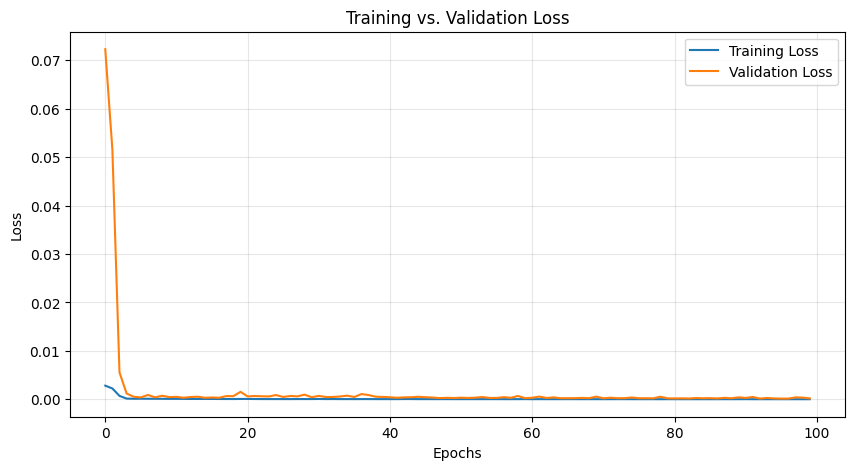

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(results['LSTM']['train_losses'], label='Training Loss')
plt.plot(results['LSTM']['val_losses'], label='Validation Loss')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Model performance comparison:


,MAE,RMSE,R2
LSTM,4.457224,5.636447,0.912008
CNN,18.967564,20.203001,-0.130483


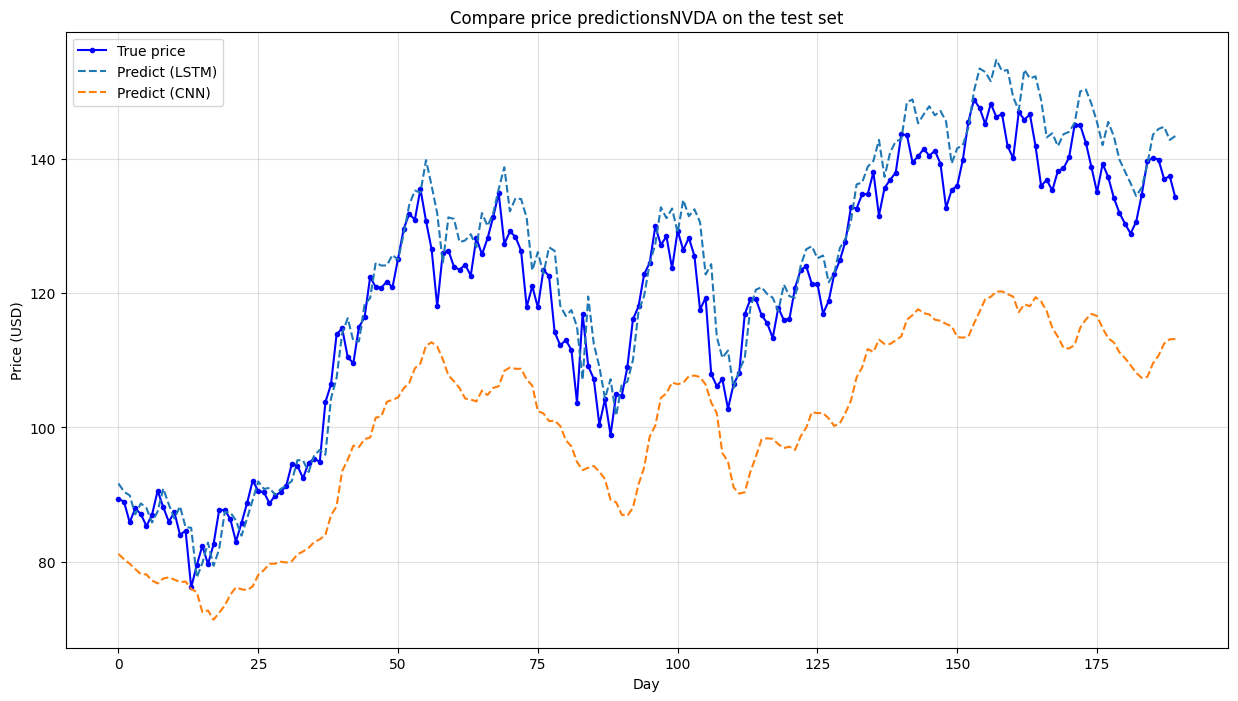

In [64]:
# create a comparision
comparison_df = pd.DataFrame({
    model: res['metrics'] for model, res in results.items()
}).T
print("Model performance comparison:")
display(comparison_df)


# Visualize on the test set
plt.figure(figsize=(15, 8))
plt.plot(results['LSTM']["true_prices"], label='True price', color='blue', marker='.')

for model_name, res in results.items():
    plt.plot(res["pred_prices"], label=f'Predict ({model_name})', linestyle='--')

plt.title(f'Compare price predictions{TICKER} on the test set')
plt.xlabel('Day')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()

## LSTM - ARO

In [67]:
def evaluate_model(params, X_train, y_train, X_val, y_val, device):
    """
    Hàm mục tiêu cho ARO. Huấn luyện một mô hình nhanh và trả về val_loss.
    """
    # 1. Giải mã và ràng buộc tham số
    hidden_size = int(max(ARO_LOWER_BOUND[0], min(ARO_UPPER_BOUND[0], params[0])))
    num_layers = int(max(ARO_LOWER_BOUND[1], min(ARO_UPPER_BOUND[1], params[1])))
    learning_rate = max(ARO_LOWER_BOUND[2], min(ARO_UPPER_BOUND[2], params[2]))

    # 2. Khởi tạo mô hình
    model = LSTMModel(
        input_size=1, 
        hidden_size=hidden_size, 
        num_layers=num_layers,
        output_size=N_FORECAST
    ).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 3. Huấn luyện nhanh (ví dụ: 20 epochs)
    epochs = 20
    model.train()
    
    X_t, y_t = X_train.to(device), y_train.to(device)
    
    for _ in range(epochs):
        optimizer.zero_grad()
        output = model(X_t)
        loss = criterion(output, y_t)
        loss.backward()
        optimizer.step()

    # 4. Đánh giá trên tập Validation
    model.eval()
    with torch.no_grad():
        X_v, y_v = X_val.to(device), y_val.to(device)
        val_pred = model(X_v)
        val_loss = criterion(val_pred, y_v).item()

    return val_loss

In [68]:
class AROOptimizer:
    def __init__(self, obj_func, lb, ub, dim, pop_size, max_iter):
        self.obj_func = obj_func
        self.lb = np.array(lb)
        self.ub = np.array(ub)
        self.dim = dim
        self.pop_size = pop_size
        self.max_iter = max_iter
        
        # Khởi tạo quần thể thỏ ngẫu nhiên
        self.rabbits = np.random.uniform(0, 1, (pop_size, dim)) * (self.ub - self.lb) + self.lb
        self.fitness = np.full(pop_size, float('inf'))
        
        self.best_rabbit = np.zeros(dim)
        self.best_fitness = float('inf')

    def optimize(self, X_train, y_train, X_val, y_val, device):
        print("Bắt đầu tối ưu hóa với ARO...")
        
        # Đánh giá ban đầu
        for i in range(self.pop_size):
            self.fitness[i] = self.obj_func(self.rabbits[i], X_train, y_train, X_val, y_val, device)
            if self.fitness[i] < self.best_fitness:
                self.best_fitness = self.fitness[i]
                self.best_rabbit = self.rabbits[i].copy()
        
        # Vòng lặp chính
        for t in range(self.max_iter):
            for i in range(self.pop_size):
                # Chiến lược 1: Detour Foraging (Khám phá)
                new_position = self.rabbits[i].copy()
                rand_idx = list(range(self.pop_size))
                rand_idx.remove(i)
                k = random.choice(rand_idx)
                
                R = (self.max_iter - t) / self.max_iter
                
                if np.random.rand() > 0.5:
                     new_position = self.rabbits[k] + R * (self.rabbits[i] - self.rabbits[k]) + \
                                    ((t / self.max_iter) * np.random.randn())
                else:
                     new_position = self.rabbits[i] + R * (np.random.rand() * (self.ub - self.lb) + self.lb - self.rabbits[i])

                # Chiến lược 2: Random Hiding (Khai thác) và kiểm tra biên
                new_position = np.clip(new_position, self.lb, self.ub)

                # Đánh giá và cập nhật
                new_fitness = self.obj_func(new_position, X_train, y_train, X_val, y_val, device)
                if new_fitness < self.fitness[i]:
                    self.fitness[i] = new_fitness
                    self.rabbits[i] = new_position
                    if new_fitness < self.best_fitness:
                        self.best_fitness = new_fitness
                        self.best_rabbit = new_position

            print(f"ARO Iteration {t+1}/{self.max_iter} - Best Val Loss: {self.best_fitness:.6f}")

        print("\n--- Kết quả tối ưu hóa ARO ---")
        print(f"Best Hidden Size: {int(self.best_rabbit[0])}")
        print(f"Best Num Layers: {int(self.best_rabbit[1])}")
        print(f"Best Learning Rate: {self.best_rabbit[2]:.6f}")
        
        return self.best_rabbit

In [71]:
aro = AROOptimizer(
    obj_func=evaluate_model, 
    lb=ARO_LOWER_BOUND, 
    ub=ARO_UPPER_BOUND, 
    dim=3, 
    pop_size=ARO_POP_SIZE, 
    max_iter=ARO_MAX_ITER
)

# Chuyển tensor sang đúng device để chạy ARO
X_train_aro = X_train_tensor.to(DEVICE)
y_train_aro = y_train_tensor.to(DEVICE)
X_val_aro = X_val_tensor.to(DEVICE)
y_val_aro = y_val_tensor.to(DEVICE)

best_params = aro.optimize(X_train_aro, y_train_aro, X_val_aro, y_val_aro, DEVICE)

# Giải mã tham số tốt nhất
opt_hidden_size = int(best_params[0])
opt_num_layers = int(best_params[1])
opt_lr = best_params[2]

Bắt đầu tối ưu hóa với ARO...
ARO Iteration 1/25 - Best Val Loss: 0.044002
ARO Iteration 2/25 - Best Val Loss: 0.017516
ARO Iteration 3/25 - Best Val Loss: 0.017516
ARO Iteration 4/25 - Best Val Loss: 0.017516
ARO Iteration 5/25 - Best Val Loss: 0.017516
ARO Iteration 6/25 - Best Val Loss: 0.017516
ARO Iteration 7/25 - Best Val Loss: 0.017516
ARO Iteration 8/25 - Best Val Loss: 0.017516
ARO Iteration 9/25 - Best Val Loss: 0.017516
ARO Iteration 10/25 - Best Val Loss: 0.017516
ARO Iteration 11/25 - Best Val Loss: 0.011987
ARO Iteration 12/25 - Best Val Loss: 0.011987
ARO Iteration 13/25 - Best Val Loss: 0.011987
ARO Iteration 14/25 - Best Val Loss: 0.011987
ARO Iteration 15/25 - Best Val Loss: 0.011987
ARO Iteration 16/25 - Best Val Loss: 0.011987
ARO Iteration 17/25 - Best Val Loss: 0.011987
ARO Iteration 18/25 - Best Val Loss: 0.011987
ARO Iteration 19/25 - Best Val Loss: 0.011987
ARO Iteration 20/25 - Best Val Loss: 0.011987
ARO Iteration 21/25 - Best Val Loss: 0.011987
ARO Iteration


--- Bắt đầu huấn luyện mô hình LSTM với tham số tối ưu từ ARO ---
Epoch [10/100], Val Loss: 0.000247
Epoch [20/100], Val Loss: 0.000149
Epoch [30/100], Val Loss: 0.000149
Epoch [40/100], Val Loss: 0.000204
Epoch [50/100], Val Loss: 0.000120
Epoch [60/100], Val Loss: 0.000125
Epoch [70/100], Val Loss: 0.000119
Epoch [80/100], Val Loss: 0.000124
Epoch [90/100], Val Loss: 0.000121
Epoch [100/100], Val Loss: 0.000134


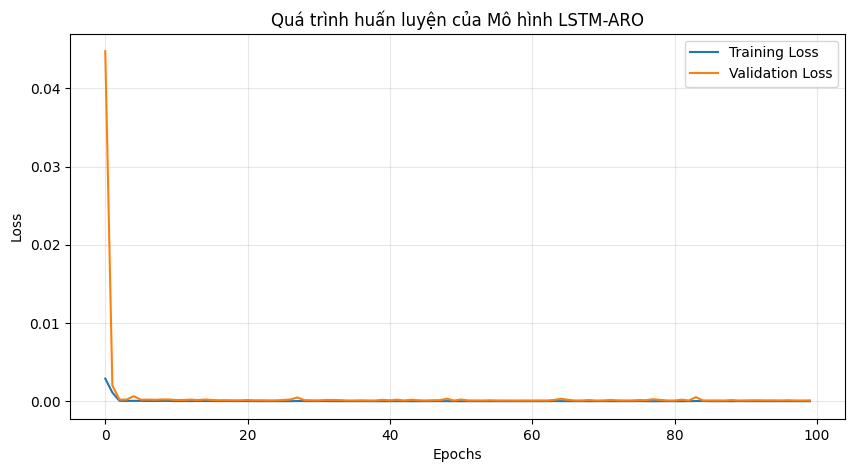

In [73]:
# Lấy các tham số tốt nhất từ kết quả của ARO
opt_hidden_size = int(best_params[0])
opt_num_layers = int(best_params[1])
opt_lr = best_params[2]

print("\n--- Bắt đầu huấn luyện mô hình LSTM với tham số tối ưu từ ARO ---")

# Khởi tạo mô hình mới với các tham số tối ưu
final_aro_model = LSTMModel(
    hidden_size=opt_hidden_size, 
    num_layers=opt_num_layers,
    output_size=N_FORECAST
).to(DEVICE)

# Khởi tạo loss và optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_aro_model.parameters(), lr=opt_lr)

# DataLoader cho việc huấn luyện theo batch
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)

# Vòng lặp huấn luyện đầy đủ
train_losses_aro, val_losses_aro = [], []

for epoch in range(EPOCHS):
    # Training
    final_aro_model.train()
    batch_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        
        optimizer.zero_grad()
        output = final_aro_model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    
    train_losses_aro.append(np.mean(batch_losses))
    
    # Validation
    final_aro_model.eval()
    with torch.no_grad():
        val_preds = final_aro_model(X_val_tensor.to(DEVICE))
        v_loss = criterion(val_preds, y_val_tensor.to(DEVICE)).item()
        val_losses_aro.append(v_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Val Loss: {v_loss:.6f}")
        
# Trực quan hóa quá trình huấn luyện của mô hình ARO-LSTM
plt.figure(figsize=(10, 5))
plt.plot(train_losses_aro, label='Training Loss')
plt.plot(val_losses_aro, label='Validation Loss')
plt.title("Quá trình huấn luyện của Mô hình LSTM-ARO")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [74]:
# Đánh giá cuối cùng trên tập Test
final_aro_model.eval()
with torch.no_grad():
    test_preds_tensor_aro = final_aro_model(X_test_tensor.to(DEVICE))
    test_preds_aro = test_preds_tensor_aro.cpu().numpy()

# Đảo ngược scale
pred_prices_aro = scaler.inverse_transform(test_preds_aro)
true_prices_aro = scaler.inverse_transform(y_test_tensor.numpy())

# Tính toán các chỉ số
mae_aro = mean_absolute_error(true_prices_aro, pred_prices_aro)
rmse_aro = np.sqrt(mean_squared_error(true_prices_aro, pred_prices_aro))
r2_aro = r2_score(true_prices_aro, pred_prices_aro)

# Lưu kết quả vào dictionary `results` để so sánh
aro_metrics = {"MAE": mae_aro, "RMSE": rmse_aro, "R2": r2_aro}
results['LSTM (ARO)'] = {
    "pred_prices": pred_prices_aro,
    "true_prices": true_prices_aro,
    "metrics": aro_metrics
}

print(f"\n📊 Kết quả của LSTM (ARO) trên tập Test:")
print(f"MAE  = {mae_aro:.2f}")
print(f"RMSE = {rmse_aro:.2f}")
print(f"R²   = {r2_aro:.3f}\n")


📊 Kết quả của LSTM (ARO) trên tập Test:
MAE  = 3.53
RMSE = 4.45
R²   = 0.945



Bảng so sánh hiệu năng các mô hình:


,MAE,RMSE,R2
LSTM (ARO),3.529163,4.449700,0.945161
LSTM,4.457224,5.636447,0.912008
CNN,18.967564,20.203001,-0.130483


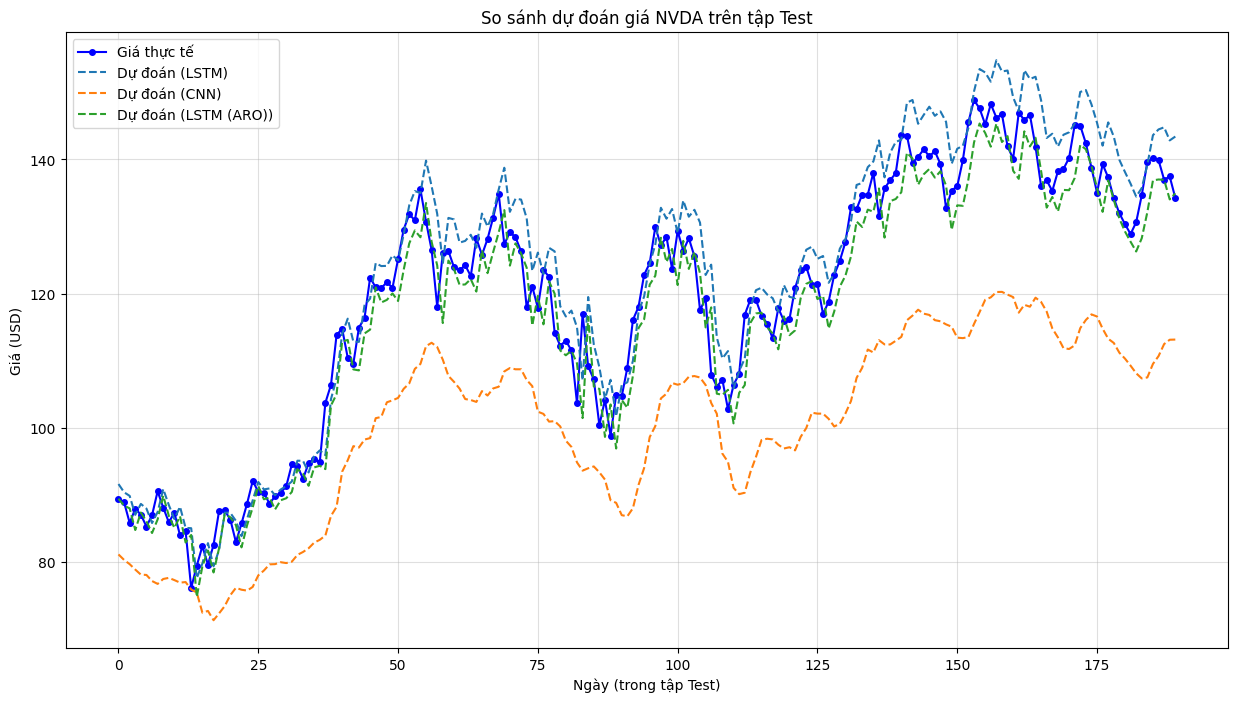

In [75]:
# Tạo bảng so sánh từ dictionary `results`
comparison_df = pd.DataFrame({
    model: res['metrics'] for model, res in results.items()
}).T.sort_values(by='RMSE', ascending=True) # Sắp xếp theo RMSE để xem mô hình nào tốt nhất

print("Bảng so sánh hiệu năng các mô hình:")
display(comparison_df)


# Trực quan hóa kết quả dự đoán của tất cả các mô hình trên tập Test
plt.figure(figsize=(15, 8))
plt.plot(results['LSTM']["true_prices"], label='Giá thực tế', color='blue', marker='o', markersize=4)

# Vẽ dự đoán của từng mô hình
for model_name, res in results.items():
    plt.plot(res["pred_prices"], label=f'Dự đoán ({model_name})', linestyle='--')

plt.title(f'So sánh dự đoán giá {TICKER} trên tập Test')
plt.xlabel('Ngày (trong tập Test)')
plt.ylabel('Giá (USD)')
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()